In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [14]:
data = pd.read_csv("cleaned_cleaned_data_combined_modified (11).csv")
def encode_labels(labels):
    unique_labels = list(set(labels))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    return np.array([label_map[label] for label in labels]), label_map

y, label_map = encode_labels(data['label'])
X = data.drop(columns=['label']).values.astype(np.float32)

def normalize(X):
    X_min, X_max = X.min(axis=0), X.max(axis=0)
    return (X - X_min) / (X_max - X_min + 1e-8), X_min, X_max

X, X_min, X_max = normalize(X)

def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    train_end = int(train_ratio * len(X))
    val_end = train_end + int(val_ratio * len(X))

    return (
        X[indices[:train_end]], y[indices[:train_end]],
        X[indices[train_end:val_end]], y[indices[train_end:val_end]],
        X[indices[val_end:]], y[indices[val_end:]]
    )

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)

Build a baseline model with a simple architecture.

In [15]:

def to_tensor(X, y):
    return torch.as_tensor(X, dtype=torch.float32).clone().detach(), torch.as_tensor(y, dtype=torch.long).clone().detach()


X_train, y_train = to_tensor(X_train, y_train)
X_val, y_val = to_tensor(X_val, y_val)
X_test, y_test = to_tensor(X_test, y_test)

class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

model = NeuralNet(X.shape[1], len(label_map))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if True:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                val_preds = torch.argmax(val_outputs, dim=1)
                val_accuracy = (val_preds == y_val).float().mean().item()
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

train(model, X_train, y_train, X_val, y_val)


Epoch 0, Train Loss: 1.0987, Val Loss: 1.0975, Val Accuracy: 0.3415
Epoch 1, Train Loss: 1.0976, Val Loss: 1.0965, Val Accuracy: 0.3415
Epoch 2, Train Loss: 1.0964, Val Loss: 1.0954, Val Accuracy: 0.3415
Epoch 3, Train Loss: 1.0952, Val Loss: 1.0943, Val Accuracy: 0.3415
Epoch 4, Train Loss: 1.0939, Val Loss: 1.0931, Val Accuracy: 0.3415
Epoch 5, Train Loss: 1.0926, Val Loss: 1.0917, Val Accuracy: 0.3415
Epoch 6, Train Loss: 1.0911, Val Loss: 1.0903, Val Accuracy: 0.3415
Epoch 7, Train Loss: 1.0895, Val Loss: 1.0887, Val Accuracy: 0.3415
Epoch 8, Train Loss: 1.0878, Val Loss: 1.0870, Val Accuracy: 0.3415
Epoch 9, Train Loss: 1.0859, Val Loss: 1.0852, Val Accuracy: 0.3415
Epoch 10, Train Loss: 1.0839, Val Loss: 1.0833, Val Accuracy: 0.3415
Epoch 11, Train Loss: 1.0818, Val Loss: 1.0812, Val Accuracy: 0.3537
Epoch 12, Train Loss: 1.0795, Val Loss: 1.0790, Val Accuracy: 0.3943
Epoch 13, Train Loss: 1.0770, Val Loss: 1.0766, Val Accuracy: 0.4309
Epoch 14, Train Loss: 1.0743, Val Loss: 1.07

In [16]:
!pip install optuna

Tune Architecture

In [17]:
import optuna

def define_model(trial, input_dim, output_dim):
    layers = []
    in_features = input_dim

    num_layers = trial.suggest_int("num_layers", 2, 5)
    for i in range(num_layers):
        out_features = trial.suggest_int(f"n_units_l{i}", 32, 256)
        layers.append(nn.Linear(in_features, out_features))

        activation_cls = trial.suggest_categorical("activation", [nn.ReLU, nn.LeakyReLU])
        layers.append(activation_cls())

        dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        in_features = out_features

    layers.append(nn.Linear(in_features, output_dim))
    layers.append(nn.Softmax(dim=1))

    return nn.Sequential(*layers)

def objective(trial):
    model = define_model(trial, X.shape[1], len(label_map))
    criterion = nn.CrossEntropyLoss()
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

    return val_loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best trial:", study.best_trial.params)


[I 2025-04-02 23:12:46,092] A new study created in memory with name: no-name-52b73c9c-bf92-45a8-93ce-2a04e9161def
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.LeakyReLU'> which is of type type.
  warnings.warn(message)
[I 2025-04-02 23:12:51,618] Trial 0 finished with value: 1.0982898473739624 and parameters: {'num_layers': 5, 'n_units_l0': 195, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'dropout': 0.3044575135399165, 'n_units_l1': 199, 'n_units_l2': 245, 'n_units_l3': 220, '

Best trial: {'num_layers': 3, 'n_units_l0': 107, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'dropout': 0.08980117367822471, 'n_units_l1': 91, 'n_units_l2': 107, 'optimizer': 'Adam', 'lr': 0.00345787258746061}


Build model with params above

In [18]:
def build_best_model(best_params, input_dim, output_dim):
    layers = []
    in_features = input_dim

    num_layers = best_params["num_layers"]
    for i in range(num_layers):
        out_features = best_params[f"n_units_l{i}"]
        layers.append(nn.Linear(in_features, out_features))
        activation = best_params["activation"]
        layers.append(nn.ReLU() if activation == "ReLU" else nn.LeakyReLU())
        if best_params["dropout"] > 0:
            layers.append(nn.Dropout(best_params["dropout"]))
        in_features = out_features

    layers.append(nn.Linear(in_features, output_dim))
    layers.append(nn.Softmax(dim=1))

    return nn.Sequential(*layers)

best_params = study.best_trial.params
model = build_best_model(best_params, X.shape[1], len(label_map))
criterion = nn.CrossEntropyLoss()
optimizer = getattr(optim, best_params["optimizer"])(model.parameters(), lr=best_params["lr"])

best_params = study.best_trial.params
model = build_best_model(best_params, X.shape[1], len(label_map))
criterion = nn.CrossEntropyLoss()
optimizer = getattr(optim, best_params["optimizer"])(model.parameters(), lr=best_params["lr"])

def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        preds = torch.argmax(outputs, dim=1)
        correct = (preds == y).sum().item()
        accuracy = correct / len(y)
    return accuracy

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        val_acc = compute_accuracy(model, X_val, y_val)
        test_acc = compute_accuracy(model, X_test, y_test)

        print(f"Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")



Epoch 0, Train Loss: 1.0984901189804077, Val Loss: 1.0973182916641235, Val Acc: 0.3049, Test Acc: 0.3306
Epoch 10, Train Loss: 0.842754602432251, Val Loss: 0.8010205626487732, Val Acc: 0.8943, Test Acc: 0.8468
Epoch 20, Train Loss: 0.6023796200752258, Val Loss: 0.6455069184303284, Val Acc: 0.9024, Test Acc: 0.8548
Epoch 30, Train Loss: 0.5866475105285645, Val Loss: 0.6399628520011902, Val Acc: 0.9106, Test Acc: 0.8427
Epoch 40, Train Loss: 0.5821050405502319, Val Loss: 0.6515946984291077, Val Acc: 0.8902, Test Acc: 0.8589


3. Optimize Learning Tune learning rate (default: 1e-3). Use Adam optimizer (default) but test alternatives like SGD. Experiment with batch size (32, 64, 128).

In [19]:
from torch.utils.data import DataLoader, TensorDataset

def objective_training(trial):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 10, 100, step=10)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    model = build_best_model(best_params, X.shape[1], len(label_map))
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = criterion(val_outputs, val_y)
                total_val_loss += val_loss.item()

    return total_val_loss / len(val_loader)

study = optuna.create_study(direction="minimize")
study.optimize(objective_training, n_trials=20)

best_training_params = study.best_trial.params
print("Best Training Params:", best_training_params)



[I 2025-04-02 23:13:31,236] A new study created in memory with name: no-name-f694cad4-d594-40a0-98c6-bfbec1acc260
<ipython-input-19-bdd5dc79931e>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-04-02 23:13:32,191] Trial 0 finished with value: 1.0990960001945496 and parameters: {'lr': 0.00144903515038864, 'optimizer': 'SGD', 'batch_size': 128, 'num_epochs': 20}. Best is trial 0 with value: 1.0990960001945496.
[I 2025-04-02 23:13:41,056] Trial 1 finished with value: 0.6465086191892624 and parameters: {'lr': 0.000678538283477453, 'optimizer': 'Adam', 'batch_size': 32, 'num_epochs': 60}. Best is trial 1 with value: 0.6465086191892624.
[I 2025-04-02 23:13:42,067] Trial 2 finished with value: 1.100091278553009 and parameters: {'lr': 0.0002708997433606872, 'optimizer': 'SGD', 'b

Best Training Params: {'lr': 0.00011874794869288928, 'optimizer': 'Adam', 'batch_size': 64, 'num_epochs': 100}


4️⃣ Fine-Tune Regularization Apply L2 weight decay (start with 1e-4).

Use early stopping (monitor validation loss).

Adjust dropout if needed.

In [20]:
def objective_regularization(trial):
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    dropout = trial.suggest_uniform("dropout", 0.0, 0.5)
    patience = trial.suggest_int("patience", 5, 20, step=5)

    lr = best_training_params["lr"]
    optimizer_name = best_training_params["optimizer"]
    batch_size = best_training_params["batch_size"]
    num_epochs = best_training_params["num_epochs"]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    model = build_best_model(best_params, X.shape[1], len(label_map))
    for layer in model.children():
        if isinstance(layer, nn.Dropout):
            layer.p = dropout

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = criterion(val_outputs, val_y)
                total_val_loss += val_loss.item()

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    return best_val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective_regularization, n_trials=20)

best_regularization_params = study.best_trial.params
print("Best Regularization Params:", best_regularization_params)


[I 2025-04-02 23:15:50,645] A new study created in memory with name: no-name-212a48b8-109b-49fb-8eb4-8381a234f2f8
<ipython-input-20-2e95977cf852>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
<ipython-input-20-2e95977cf852>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.0, 0.5)
[I 2025-04-02 23:15:55,571] Trial 0 finished with value: 2.553502380847931 and parameters: {'weight_decay': 1.0895447514886899e-06, 'dropout': 0.450728312291086, 'patience': 5}. Best is trial 0 with value: 2.553502380847931.


Early stopping triggered at epoch 48


[I 2025-04-02 23:16:01,996] Trial 1 finished with value: 2.5458779335021973 and parameters: {'weight_decay': 0.00018410411669725547, 'dropout': 0.46106112196157256, 'patience': 15}. Best is trial 1 with value: 2.5458779335021973.


Early stopping triggered at epoch 72


[I 2025-04-02 23:16:08,218] Trial 2 finished with value: 2.573693811893463 and parameters: {'weight_decay': 8.770165145388512e-06, 'dropout': 0.02998224333708882, 'patience': 20}. Best is trial 1 with value: 2.5458779335021973.


Early stopping triggered at epoch 62


[I 2025-04-02 23:16:12,982] Trial 3 finished with value: 2.5553946495056152 and parameters: {'weight_decay': 0.0005581232097304635, 'dropout': 0.2189118754652199, 'patience': 10}. Best is trial 1 with value: 2.5458779335021973.


Early stopping triggered at epoch 55


[I 2025-04-02 23:16:21,072] Trial 4 finished with value: 2.5498324036598206 and parameters: {'weight_decay': 7.136887108135883e-05, 'dropout': 0.41876082548727867, 'patience': 20}. Best is trial 1 with value: 2.5458779335021973.


Early stopping triggered at epoch 80


[I 2025-04-02 23:16:24,629] Trial 5 finished with value: 2.554466128349304 and parameters: {'weight_decay': 1.0033731047454496e-06, 'dropout': 0.2059220565642667, 'patience': 5}. Best is trial 1 with value: 2.5458779335021973.


Early stopping triggered at epoch 41


[I 2025-04-02 23:16:29,980] Trial 6 finished with value: 2.544512152671814 and parameters: {'weight_decay': 1.184260810721892e-05, 'dropout': 0.39500366820991567, 'patience': 10}. Best is trial 6 with value: 2.544512152671814.


Early stopping triggered at epoch 57


[I 2025-04-02 23:16:36,179] Trial 7 finished with value: 2.5269232392311096 and parameters: {'weight_decay': 1.2422878006084067e-05, 'dropout': 0.42301985391682667, 'patience': 15}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 67


[I 2025-04-02 23:16:39,683] Trial 8 finished with value: 2.561427652835846 and parameters: {'weight_decay': 2.600477897526616e-05, 'dropout': 0.17163446383540315, 'patience': 5}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 40


[I 2025-04-02 23:16:45,915] Trial 9 finished with value: 2.5476551055908203 and parameters: {'weight_decay': 2.219763569702328e-06, 'dropout': 0.1472905642117467, 'patience': 10}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 62


[I 2025-04-02 23:16:51,206] Trial 10 finished with value: 2.534570574760437 and parameters: {'weight_decay': 6.220615369326881e-06, 'dropout': 0.3198398012254047, 'patience': 15}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 61


[I 2025-04-02 23:16:57,800] Trial 11 finished with value: 2.534649968147278 and parameters: {'weight_decay': 6.2648244993367225e-06, 'dropout': 0.31975491458824107, 'patience': 15}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 66


[I 2025-04-02 23:17:04,236] Trial 12 finished with value: 2.5559878945350647 and parameters: {'weight_decay': 3.0863095335356294e-05, 'dropout': 0.31224713267070603, 'patience': 15}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 63


[I 2025-04-02 23:17:12,091] Trial 13 finished with value: 2.545979857444763 and parameters: {'weight_decay': 3.296797045520848e-06, 'dropout': 0.33511969266444547, 'patience': 15}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 71


[I 2025-04-02 23:17:17,901] Trial 14 finished with value: 2.544826924800873 and parameters: {'weight_decay': 9.248263808338771e-05, 'dropout': 0.36555522243694305, 'patience': 20}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 67


[I 2025-04-02 23:17:25,861] Trial 15 finished with value: 2.536063253879547 and parameters: {'weight_decay': 1.5160336118296167e-05, 'dropout': 0.4960007859958746, 'patience': 15}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 80


[I 2025-04-02 23:17:30,445] Trial 16 finished with value: 2.5482181906700134 and parameters: {'weight_decay': 4.160103157106675e-06, 'dropout': 0.27302403569991873, 'patience': 10}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 53


[I 2025-04-02 23:17:38,634] Trial 17 finished with value: 2.5567485690116882 and parameters: {'weight_decay': 6.171101422687596e-05, 'dropout': 0.08713857077702258, 'patience': 20}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 81


[I 2025-04-02 23:17:47,939] Trial 18 finished with value: 2.5411813855171204 and parameters: {'weight_decay': 1.916856886760123e-05, 'dropout': 0.2670945659248966, 'patience': 15}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 92


[I 2025-04-02 23:17:53,285] Trial 19 finished with value: 2.551333963871002 and parameters: {'weight_decay': 2.050576987182233e-06, 'dropout': 0.40981996177198543, 'patience': 10}. Best is trial 7 with value: 2.5269232392311096.


Early stopping triggered at epoch 63
Best Regularization Params: {'weight_decay': 1.2422878006084067e-05, 'dropout': 0.42301985391682667, 'patience': 15}


Final model

Epoch 1/100, Train Acc: 33.30%, Validation Acc: 30.49%
Epoch 2/100, Train Acc: 35.48%, Validation Acc: 30.49%
Epoch 3/100, Train Acc: 38.26%, Validation Acc: 30.49%
Epoch 4/100, Train Acc: 42.52%, Validation Acc: 33.33%
Epoch 5/100, Train Acc: 44.43%, Validation Acc: 48.37%
Epoch 6/100, Train Acc: 53.13%, Validation Acc: 63.82%
Epoch 7/100, Train Acc: 55.39%, Validation Acc: 70.33%
Epoch 8/100, Train Acc: 62.35%, Validation Acc: 69.51%
Epoch 9/100, Train Acc: 63.30%, Validation Acc: 63.82%
Epoch 10/100, Train Acc: 62.09%, Validation Acc: 63.41%
Epoch 11/100, Train Acc: 62.35%, Validation Acc: 65.85%
Epoch 12/100, Train Acc: 66.87%, Validation Acc: 69.51%
Epoch 13/100, Train Acc: 69.30%, Validation Acc: 74.80%
Epoch 14/100, Train Acc: 75.13%, Validation Acc: 78.46%
Epoch 15/100, Train Acc: 80.87%, Validation Acc: 82.93%
Epoch 16/100, Train Acc: 83.04%, Validation Acc: 85.37%
Epoch 17/100, Train Acc: 85.22%, Validation Acc: 87.40%
Epoch 18/100, Train Acc: 86.87%, Validation Acc: 88.21%
E

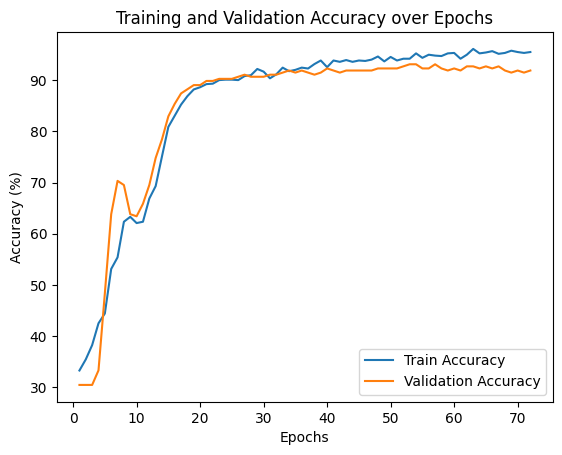

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def build_final_model():
    model = build_best_model(best_params, X.shape[1], len(label_map))

    for layer in model.children():
        if isinstance(layer, nn.Dropout):
            layer.p = best_regularization_params['dropout']

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, best_training_params['optimizer'])(
        model.parameters(),
        lr=best_training_params['lr'],
        weight_decay=best_regularization_params['weight_decay']
    )

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=best_training_params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=best_training_params['batch_size'], shuffle=False)

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    train_accuracies = []
    val_accuracies = []

    for epoch in range(best_training_params['num_epochs']):
        model.train()
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_y).sum().item()
            total_train += batch_y.size(0)

        train_accuracy = correct_train / total_train * 100
        train_accuracies.append(train_accuracy)

        model.eval()
        correct_val = 0
        total_val = 0
        total_val_loss = 0

        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = criterion(val_outputs, val_y)
                total_val_loss += val_loss.item()

                _, predicted = torch.max(val_outputs, 1)
                correct_val += (predicted == val_y).sum().item()
                total_val += val_y.size(0)

        val_accuracy = correct_val / total_val * 100
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{best_training_params['num_epochs']}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {val_accuracy:.2f}%")

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= best_regularization_params['patience']:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

    return model

final_model = build_final_model()


In [22]:
def evaluate_model(model, X_test, y_test):
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=best_training_params['batch_size'], shuffle=False)

    criterion = nn.CrossEntropyLoss()

    model.eval()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_y).sum().item()
            total_samples += batch_y.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100

    return avg_loss, accuracy

test_loss, test_accuracy = evaluate_model(final_model, X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.6854
Test Accuracy: 86.29%


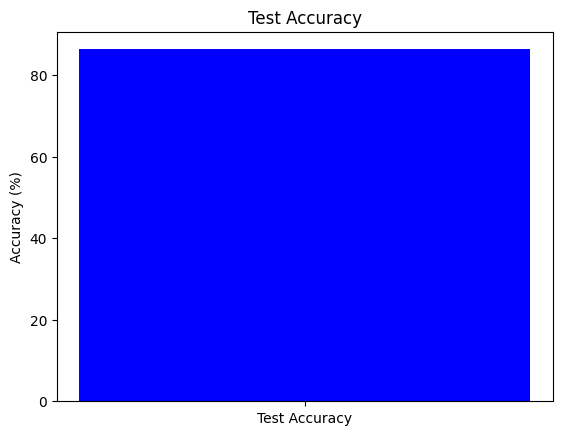

In [26]:
plt.figure()
plt.bar(['Test Accuracy'], [test_accuracy], color='blue')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.show()


1️⃣ Build a Baseline Model
First, we'll construct a simple neural network with:

Input layer: Takes in all features.

Hidden layers: Two layers with ReLU activation.

Output layer: Uses Softmax (since it's a classification problem).

2️⃣ Tune Architecture
Try increasing depth (number of layers).

Adjust width (neurons per layer).

Experiment with activation functions (ReLU, LeakyReLU, etc.).

Add dropout for regularization.

3️⃣ Optimize Learning
Tune learning rate (default: 1e-3).

Use Adam optimizer (default) but test alternatives like SGD.

Experiment with batch size (32, 64, 128).

4️⃣ Fine-Tune Regularization
Apply L2 weight decay (start with 1e-4).

Use early stopping (monitor validation loss).

Adjust dropout if needed.

5️⃣ Automate with Hyperparameter Tuning
Use Optuna or Hyperopt to search for the best configuration.